<a href="https://colab.research.google.com/github/aandre35/bitcoin-prediction/blob/main/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels

Requirement already up-to-date: Cython in /usr/local/lib/python3.7/dist-packages (0.29.22)
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-za7cj3dj
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-za7cj3dj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+292.gd42dc3f3c-cp37-cp37m-linux_x86_64.whl size=17614957 sha256=1d2aeba7e159da89abfe6bcc714ddec40184dff4b1a516a320c4d7af40c67608
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5u_9zlu/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np

#keras
import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator

#sklearn
from sklearn.preprocessing import MinMaxScaler

#display
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
sns.set_theme()

#statsmodels
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
import pandas_datareader as pdr
import datetime
btc_data = pdr.get_data_yahoo(['BTC-USD'], 
                          start=datetime.datetime(2014, 9, 16), 
                          end=datetime.datetime(2021, 4, 2))
btc_data.head()

Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,,
2014-09-16,457.334015,457.334015,468.174011,452.421997,465.864014,21056800.0
2014-09-17,424.440002,424.440002,456.859985,413.104004,456.859985,34483200.0
2014-09-18,394.795990,394.795990,427.834991,384.532013,424.102997,37919700.0
2014-09-19,408.903992,408.903992,423.295990,389.882996,394.673004,36863600.0
2014-09-20,398.821014,398.821014,412.425995,393.181000,408.084991,26580100.0


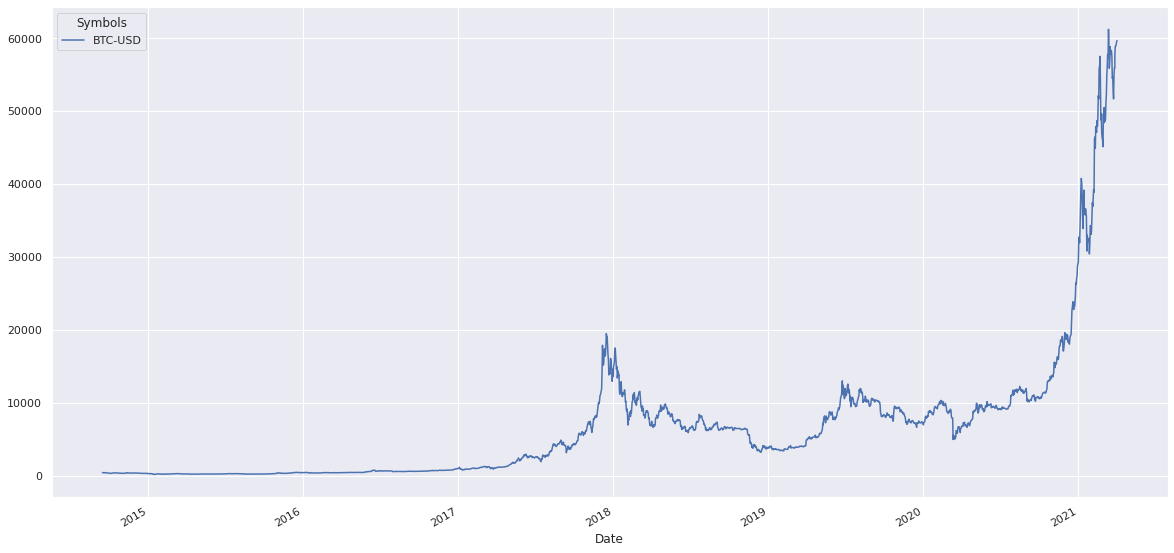

In [ ]:
btc_data['Close'].plot(figsize=(20,10))

## Entrainement avec un ensemble de test

In [ ]:
Real_Price = btc_data['Close']['BTC-USD']
Real_Price.head()

Date
2014-09-16    457.334015
2014-09-17    424.440002
2014-09-18    394.795990
2014-09-19    408.903992
2014-09-20    398.821014
Name: BTC-USD, dtype: float64

In [ ]:
# split data
PREDICTIONS_DAYS = 30
N_FEATURES = 1
WINDOW_SIZE = 10
BATCH_SIZE = 8

# split data frames into train and test
df_train = Real_Price[:len(Real_Price)-PREDICTIONS_DAYS]
df_val = Real_Price[len(Real_Price)-PREDICTIONS_DAYS:]
df_test = Real_Price[len(Real_Price)-PREDICTIONS_DAYS-WINDOW_SIZE:]

# values
train_values = df_train.values
val_values = df_val.values
test_values = df_test.values
all_values = Real_Price.values

series_train= np.reshape(train_values, (len(train_values), N_FEATURES))
series_val = np.reshape(val_values, (len(val_values), N_FEATURES))
series_test = np.reshape(test_values, (len(test_values), N_FEATURES))
series = np.reshape(all_values, (len(all_values), N_FEATURES))

sc = MinMaxScaler()
series_train = sc.fit_transform(series_train)
series_val = sc.transform(series_val)
series_test = sc.transform(series_test)

# define generator
train_generator = TimeseriesGenerator(series_train, series_train, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
val_generator = TimeseriesGenerator(series_val, series_val, length=WINDOW_SIZE, batch_size=BATCH_SIZE)
test_generator = TimeseriesGenerator(series_test, series_test, length=WINDOW_SIZE, batch_size=BATCH_SIZE)

In [ ]:
def build_model():
  # Initialising the RNN
  model = Sequential()

  # Adding the input layer and the LSTM layer
  model.add(LSTM(units = 200, activation = 'sigmoid', input_shape = (WINDOW_SIZE, 1)))

  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'MSE', metrics=["mae"])

  # Fitting the RNN to the Training set
  model.summary()

  return model

In [ ]:
model = build_model()
history = model.fit(train_generator, validation_data = val_generator, epochs = 10)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
294/294 [==============================] - 9s 28ms/step - loss: 0.0277 - mae: 0.1305 - val_loss: 0.5065 - val_mae: 0.7107
Epoch 2/10
294/294 [==============================] - 8s 27ms/step - loss: 0.0147 - mae: 0.0874 - val_loss: 0.3251 - val_mae: 0.5692
Epoch 3/10
294/294 [==============================] - 8s 27ms/step - loss: 0.0049 - mae: 0.0523 - val_loss: 0.1117 - val_mae: 0.3326
Epoch 4/10
294/294 [==============================] - 8s 27ms/step - loss: 0.0025 - mae: 0.0380 - val_loss: 0.0

In [ ]:
def plot_training_analysis(history, metric='loss'):    

  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()
  plt.ylim((0,0.05))
  plt.show()

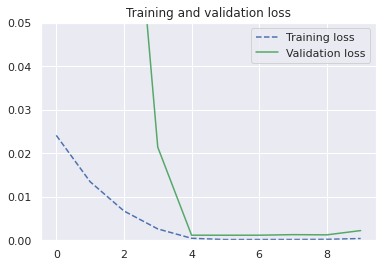

In [ ]:
plot_training_analysis(history)

In [ ]:
def join_df(train_datetime, train_values, test_datetime, test_values):
    test_values = np.reshape(test_values, (len(test_values)))
    datetime = np.append(train_datetime, test_datetime, axis=0)
    values = np.append(train_values, test_values, axis=0)
    label_train = ['train' for x in train_values]
    label_test = ['test' for x in test_values]
    label = np.append(label_train, label_test, axis=0)
    df_pred = pd.DataFrame(data = np.transpose([datetime, label, values]), columns = ["datetime", "label", "value"])
    df_pred['datetime'] = pd.to_datetime(df_pred['datetime'])
    df_pred.set_index('datetime', inplace=True)
    df_pred = df_pred.astype({"value" : "float32"})
    return df_pred

In [ ]:
y_test_pred = sc.inverse_transform(model.predict(test_generator))
print(y_test_pred.shape)
df_pred = join_df(df_train.index, df_train.values, df_val.index, y_test_pred)
df_pred.head()

(30, 1)


,label,value
datetime,,
2014-09-16,train,457.334015
2014-09-17,train,424.440002
2014-09-18,train,394.795990
2014-09-19,train,408.903992
2014-09-20,train,398.821014


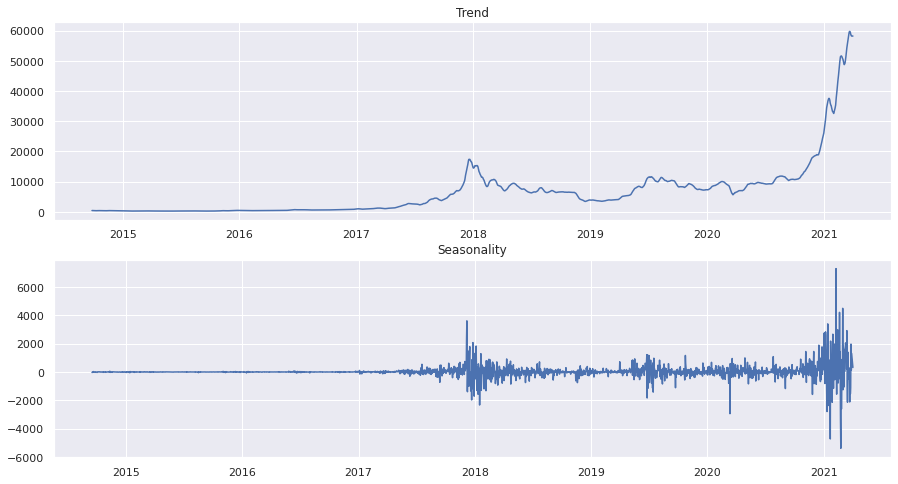

In [ ]:
value = df_pred[['value']]

plt.figure(figsize=(15,8))

plt.subplot(211)
plt.plot(value.rolling(12).mean())
plt.title("Trend")

plt.subplot(212)
plt.title("Seasonality")
plt.plot(value.diff())

In [ ]:
df_pred.head()

,label,value
datetime,,
2014-09-16,train,457.334015
2014-09-17,train,424.440002
2014-09-18,train,394.795990
2014-09-19,train,408.903992
2014-09-20,train,398.821014


In [ ]:
df_test.head()

Date
2021-02-21    57539.945312
2021-02-22    54207.320312
2021-02-23    48824.425781
2021-02-24    49705.332031
2021-02-25    47093.851562
Name: BTC-USD, dtype: float64

In [ ]:
fig = px.line(df_pred, x = df_pred.index, y = "value", color="label")

fig.show()

In [ ]:
date = df_pred.index

# Create traces
fig = px.line(df_pred, x = df_pred.index, y = df_pred.value.values, color='label')
fig.add_trace(go.Scatter(x = df_val.index, y = df_val.values,
                    mode='lines+markers', name= "true values"))

fig.show()

## Forecasting

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


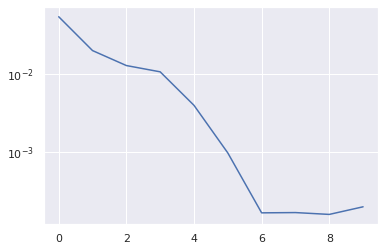

In [ ]:
sc = MinMaxScaler()
series_forecasting = sc.fit_transform(all_values.reshape(-1, 1))
generator_forecasting = TimeseriesGenerator(series_forecasting, series_forecasting, 
                                            length=WINDOW_SIZE, batch_size=8)
# fit model
model = build_model()
history = model.fit(generator_forecasting, epochs=10, verbose=0)
plt.plot(history.history["loss"])
plt.yscale('log')
plt.show()

In [ ]:
def forecast_lstm(series_forecasting, nb_val):
    predictions = list()
    series_f = series_forecasting.copy()
    for i in range(nb_val):
        prediction = model.predict(np.expand_dims(series_f[-WINDOW_SIZE:], axis=0))
        yhat = prediction[-1]

        #Append forecasted value
        predictions.append(yhat)
        series_f = np.append(series_f, [yhat], axis=0)
    
    return predictions

In [ ]:
# datetimes of train and test dataset
datetimes = df_train.index
dt_forecast = pd.date_range(start = datetimes[-1]+ datetime.timedelta(days=1), end=datetime.datetime(2021, 5, 8))

# Number of value to forecast
NB_VAL = len(dt_forecast)

# compute predictions
predictions_lstm = forecast_lstm(series_forecasting, NB_VAL)

# inverse transformation of MinMaxScaler
predictions_lstm = sc.inverse_transform(predictions_lstm)

# join train df and test predicted df
df_forecast_lstm = join_df(df_train.index, df_train.values, dt_forecast, predictions_lstm)
df_forecast_lstm.tail(5)

,label,value
datetime,,
2021-05-04,test,64143.828125
2021-05-05,test,64227.109375
2021-05-06,test,64310.324219
2021-05-07,test,64393.449219
2021-05-08,test,64476.492188


In [ ]:
fig = px.line(df_forecast_lstm, x=df_forecast_lstm.index, y="value", color="label")
fig.show()

In [ ]:
date=df_forecast_lstm.index

# Create traces
fig = px.line(df_forecast_lstm,x=df_forecast_lstm.index, y=df_forecast_lstm.value.values, color='label')
fig.add_trace(go.Scatter(x=df_val.index, y=df_val.values,
                    mode='lines+markers', name= "true values"))

fig.show()

## ARIMA

In [ ]:
def forecast_arima(nb_val):
    history = train_values.copy()
    predictions = list()
    for i in range(NB_VAL):
        model = ARIMA(history, order = (WINDOW_SIZE,1,0))
        model_fit = model.fit()

        output = model_fit.forecast()
        yhat = output[0]
        # save forecasted value
        history = np.append(history, output, axis=0)
        predictions.append(yhat)
        
    return predictions

In [ ]:
predictions_arima = forecast_arima(NB_VAL)

In [ ]:
df_forecast_arima = join_df(df_train.index, df_train.values, dt_forecast, predictions_arima)
df_forecast_arima.tail(5)

,label,value
datetime,,
2021-05-04,test,46249.277344
2021-05-05,test,46249.101562
2021-05-06,test,46249.058594
2021-05-07,test,46249.187500
2021-05-08,test,46248.976562


In [ ]:
fig = px.line(df_forecast_arima, x=df_forecast_arima.index, y="value", color="label")
fig.show()

In [ ]:
date=df_forecast_lstm.index

# Create traces
fig = px.line(df_forecast_arima,x=df_forecast_arima.index, y=df_forecast_arima.value.values, color='label')
fig.add_trace(go.Scatter(x=df_val.index, y=df_val.values,
                    mode='lines+markers', name= "true values"))

fig.show()

## Prophet

In [ ]:
### Prophet
from fbprophet import Prophet

columns = ["ds", "y"]
df_prophet = pd.DataFrame(columns = columns)
df_prophet["ds"] = Real_Price.index
df_prophet["y"] = Real_Price.values

sc = MinMaxScaler()
df_prophet["y"] = sc.fit_transform(np.reshape(df_prophet.y.values, (-1, 1)))
df_prophet.head()

,ds,y
0,2014-09-16,0.004573
1,2014-09-17,0.004034
2,2014-09-18,0.003549
3,2014-09-19,0.003780
4,2014-09-20,0.003614


In [ ]:
m = Prophet()
m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Python
future = m.make_future_dataframe(freq='s', periods=NB_VAL, include_history=True)
future.tail()

,ds
2440,2021-04-02 00:01:03
2441,2021-04-02 00:01:04
2442,2021-04-02 00:01:05
2443,2021-04-02 00:01:06
2444,2021-04-02 00:01:07


In [ ]:
# Python
forecast_prophet = m.predict(future)
forecast_prophet.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2440,2021-04-02 00:01:03,0.560718,0.484921,0.657973,0.560718,0.560718,0.010305,0.010305,0.010305,0.00082,0.00082,0.00082,0.009485,0.009485,0.009485,0.0,0.0,0.0,0.571023
2441,2021-04-02 00:01:04,0.560718,0.482239,0.659082,0.560718,0.560718,0.010305,0.010305,0.010305,0.00082,0.00082,0.00082,0.009485,0.009485,0.009485,0.0,0.0,0.0,0.571023
2442,2021-04-02 00:01:05,0.560718,0.487771,0.657683,0.560718,0.560718,0.010305,0.010305,0.010305,0.00082,0.00082,0.00082,0.009485,0.009485,0.009485,0.0,0.0,0.0,0.571023
2443,2021-04-02 00:01:06,0.560718,0.482871,0.661028,0.560718,0.560718,0.010305,0.010305,0.010305,0.00082,0.00082,0.00082,0.009485,0.009485,0.009485,0.0,0.0,0.0,0.571023
2444,2021-04-02 00:01:07,0.560718,0.481751,0.656495,0.560718,0.560718,0.010305,0.010305,0.010305,0.00082,0.00082,0.00082,0.009485,0.009485,0.009485,0.0,0.0,0.0,0.571022


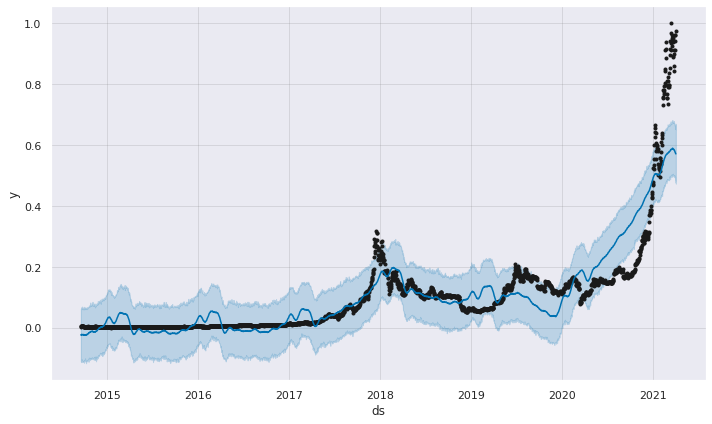

In [ ]:
fig1 = m.plot(forecast_prophet)

## TO DO : predictions on more than one day with LSTM